In [203]:
import cartpole as cart
import math, random
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

In [204]:
import matplotlib.pyplot as plt

In [205]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def length(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(1000)

In [206]:
env = gym.make('CartPole-v1')

In [207]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [208]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128), #4, 128
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, x):
        return self.layers(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)

            action  = q_value.argmax().item()

        else:
            action = random.randrange(env.action_space.n) #0 or 1
        return action

current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

4


In [209]:

optimizer = optim.Adam(current_model.parameters())



In [210]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())


In [211]:
update_target(current_model, target_model)


In [212]:
def compute_td_loss(batch_size, gamma):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state)

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - expected_q_value.data).pow(2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [213]:
def plot(frame_idx, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

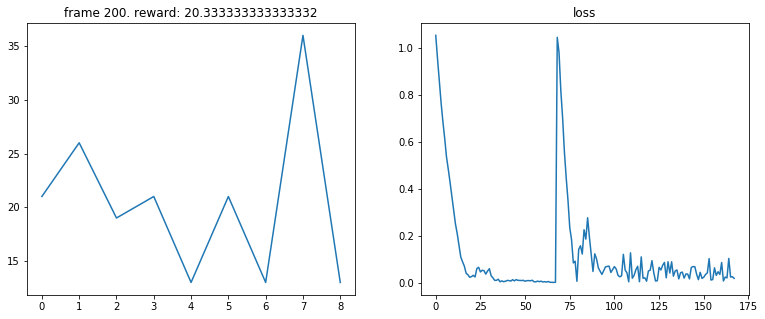

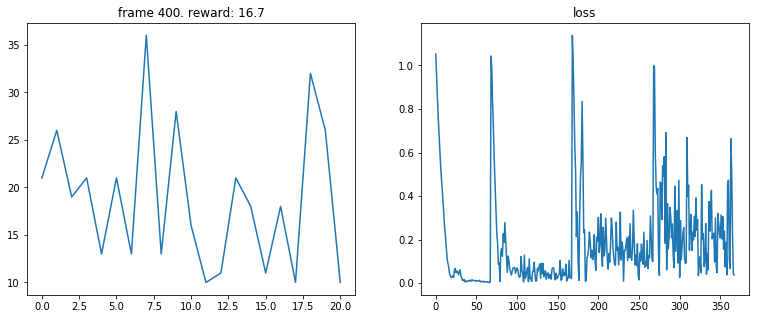

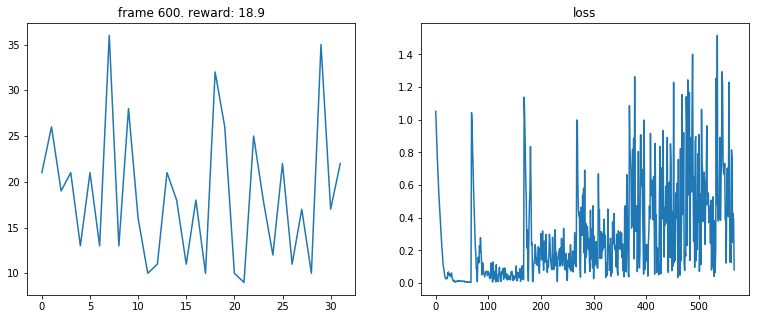

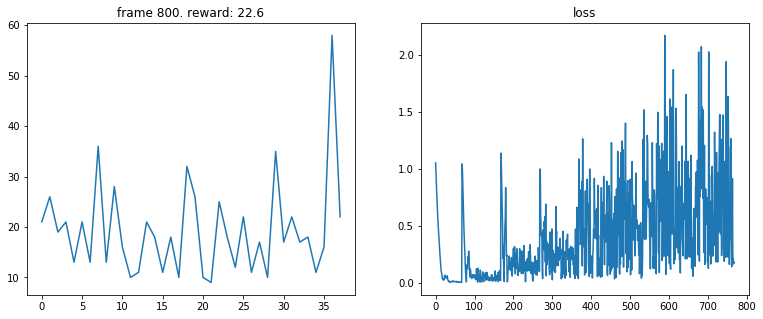

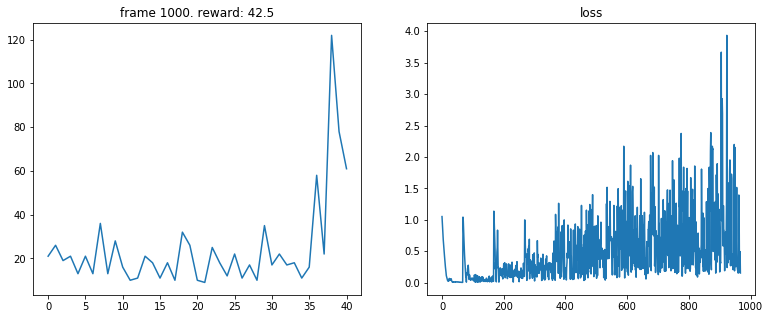

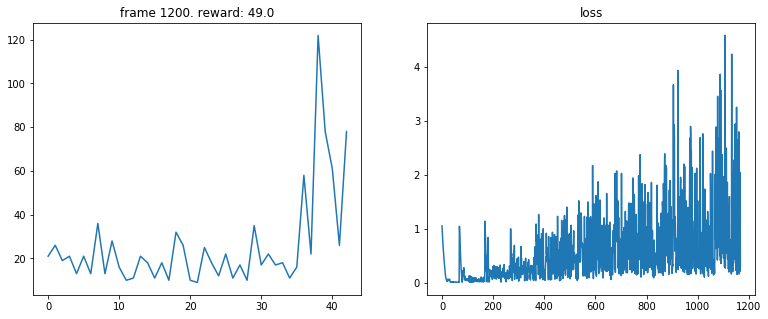

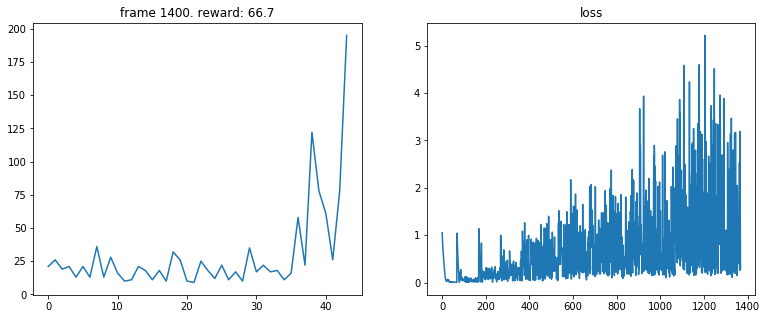

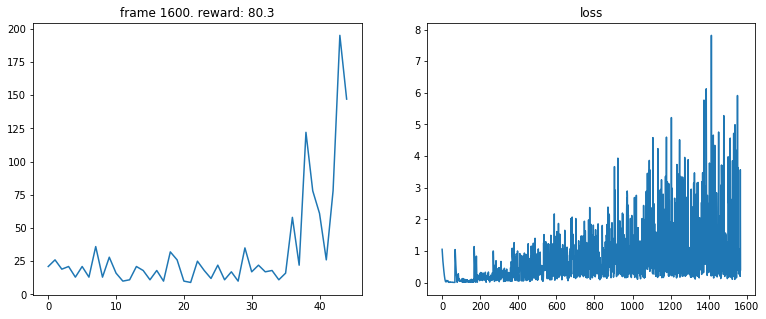

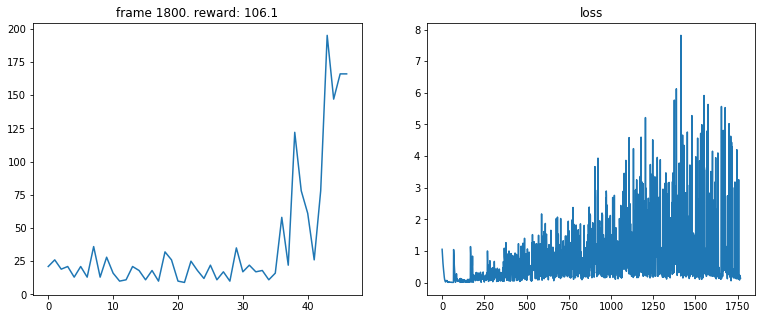

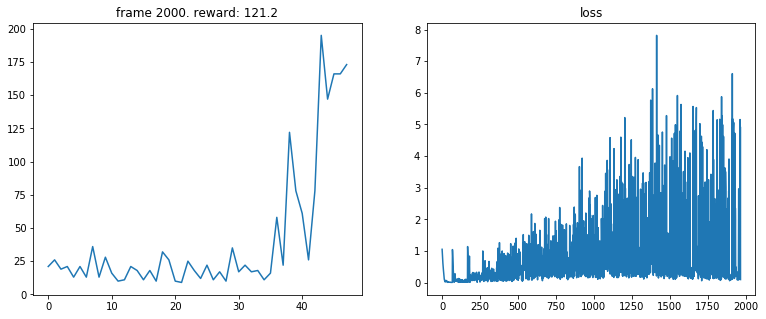

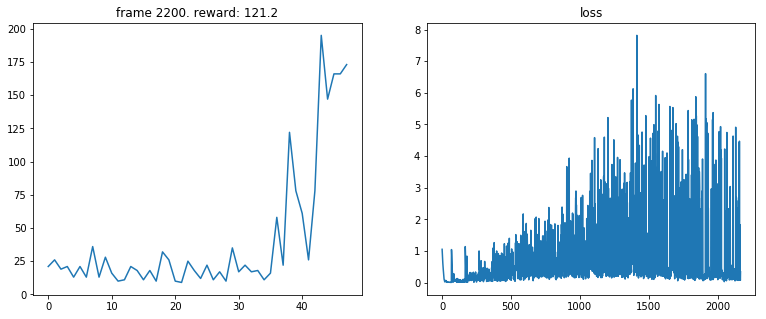

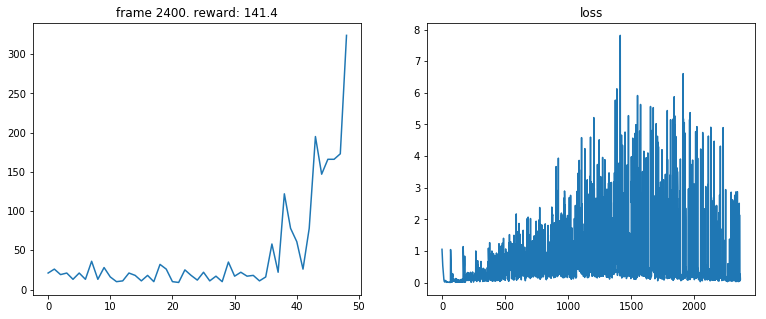

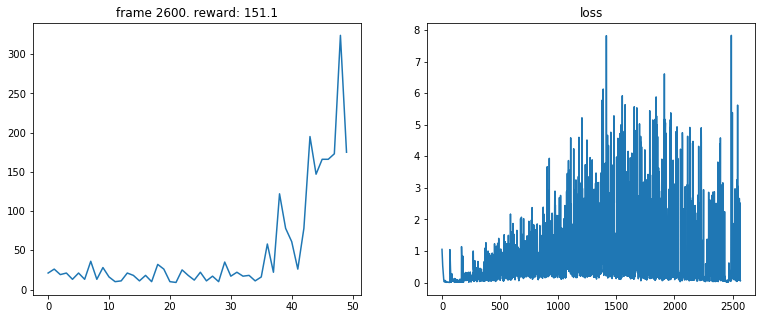

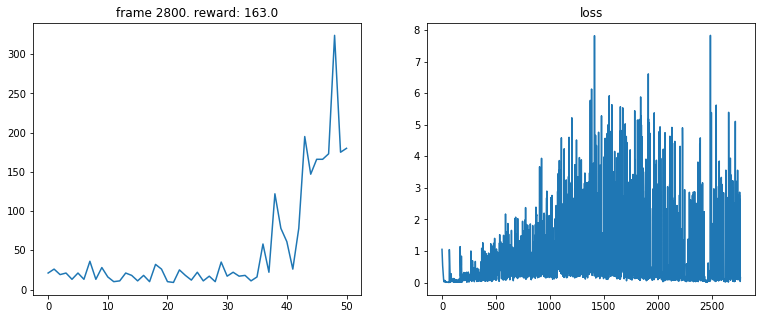

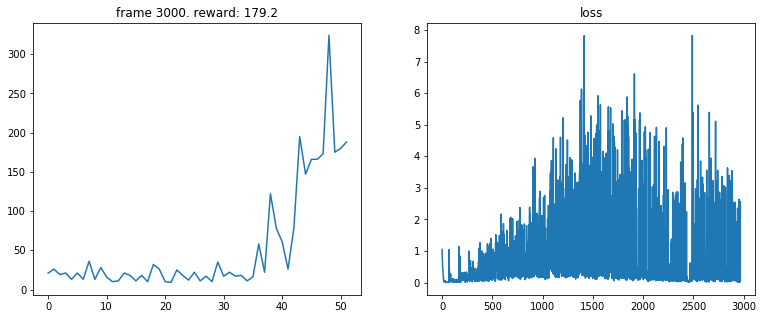

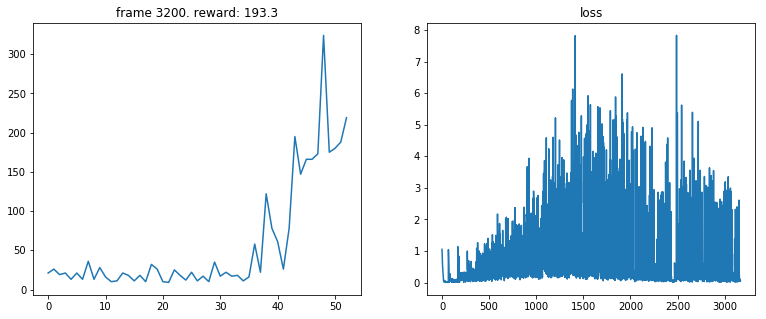

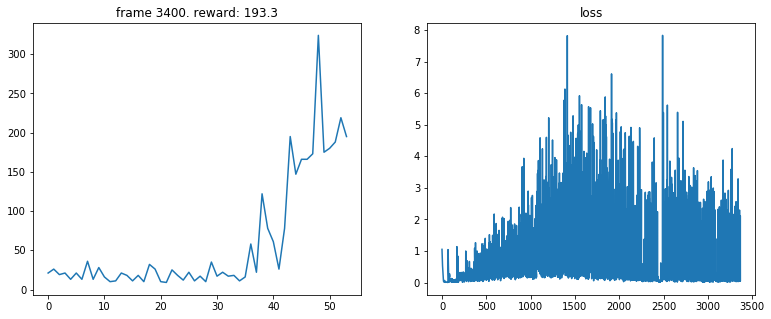

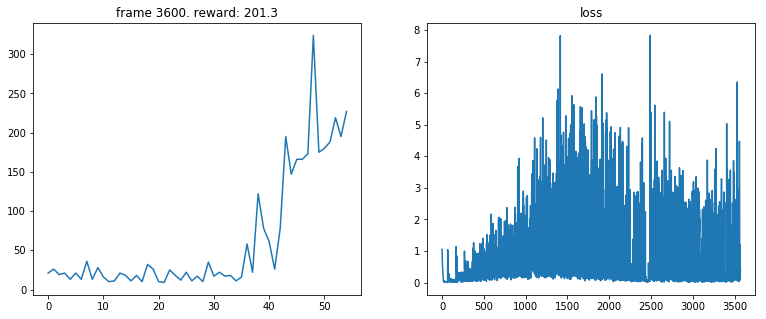

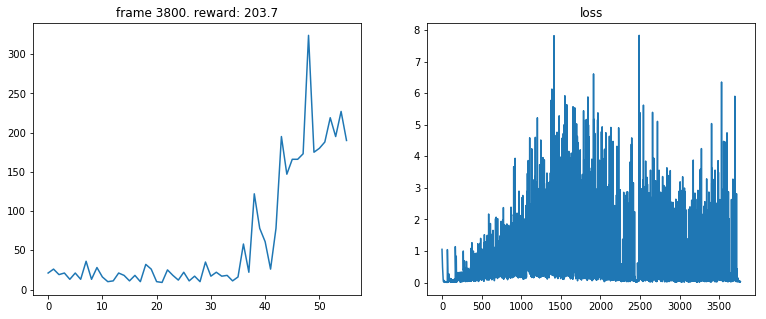

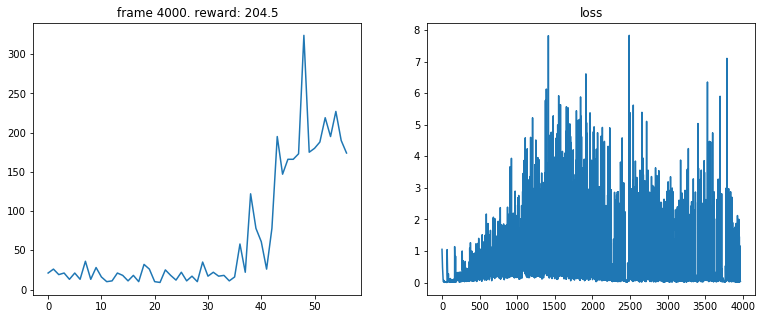

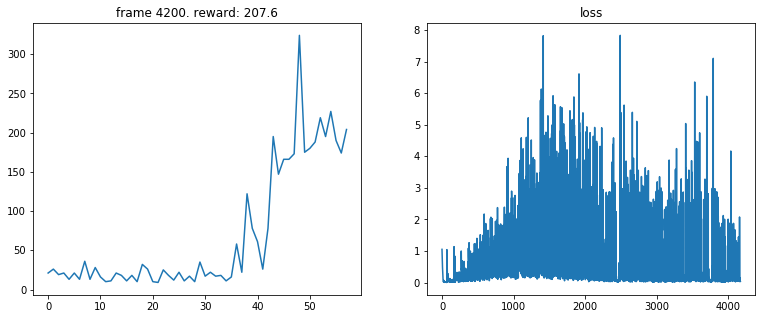

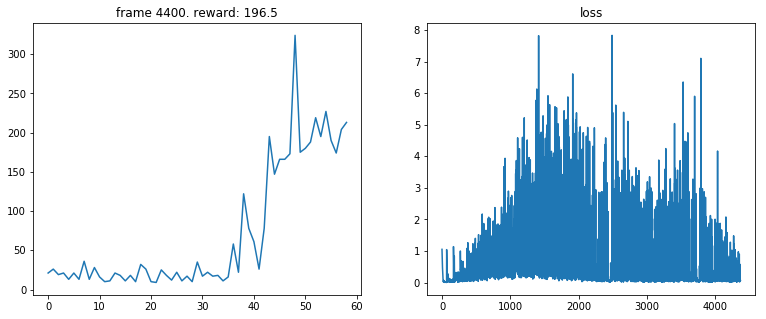

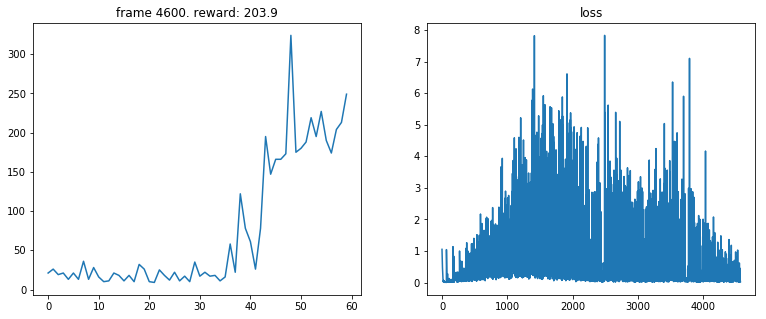

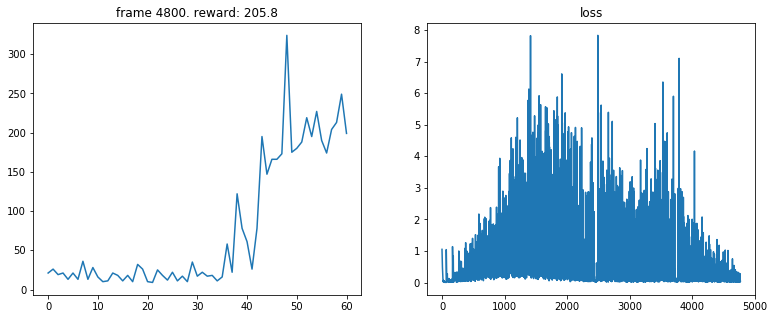

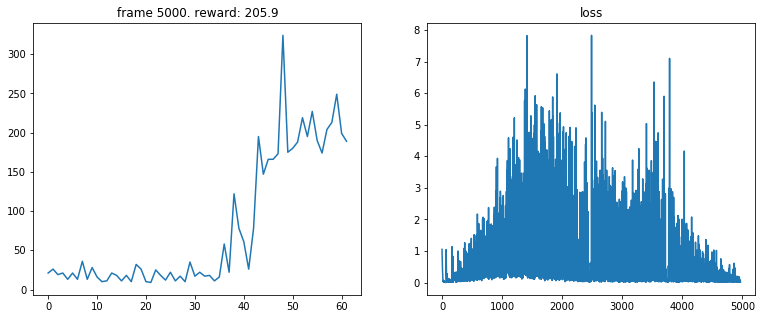

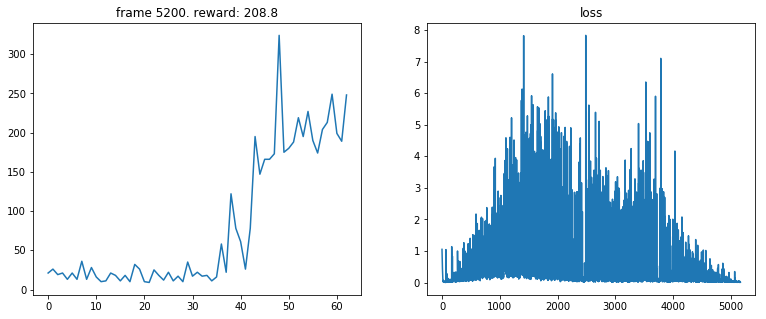

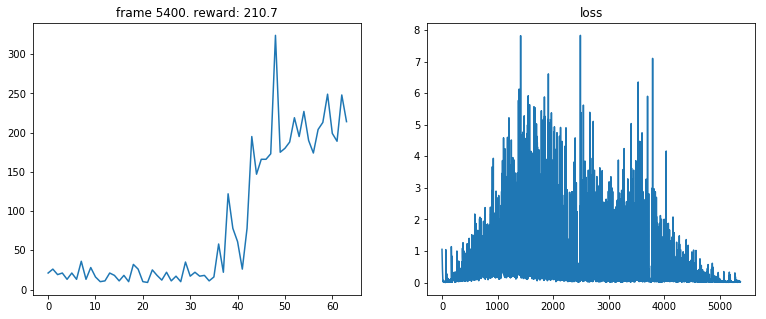

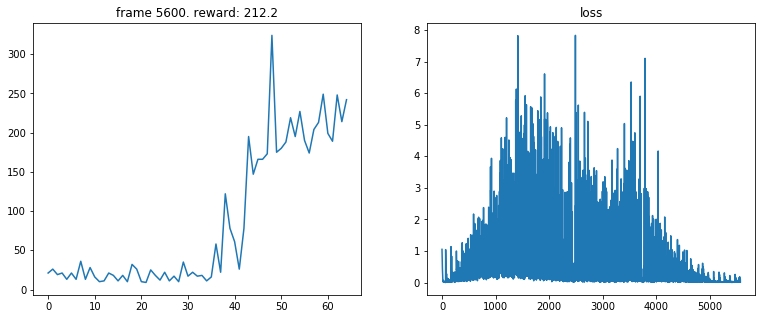

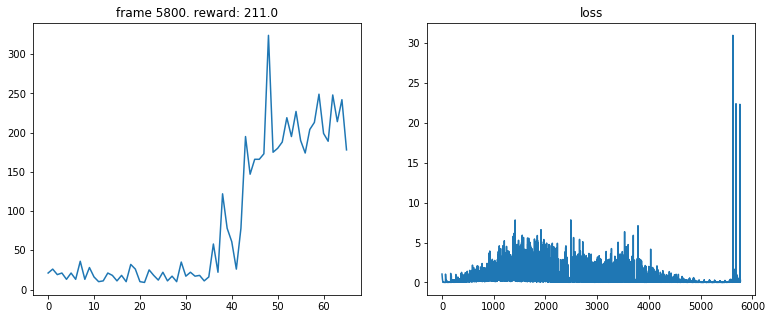

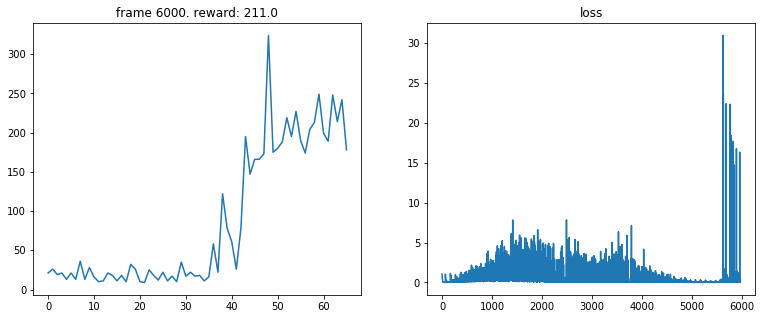

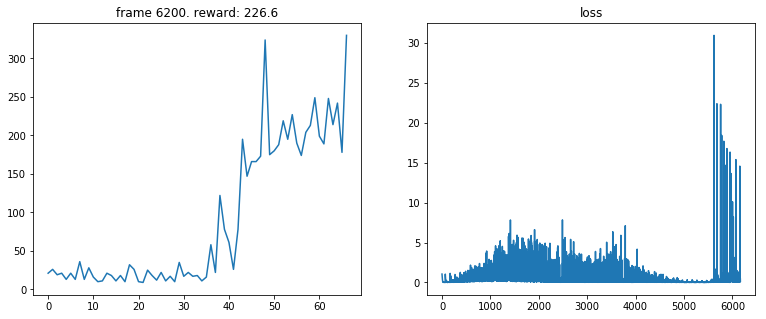

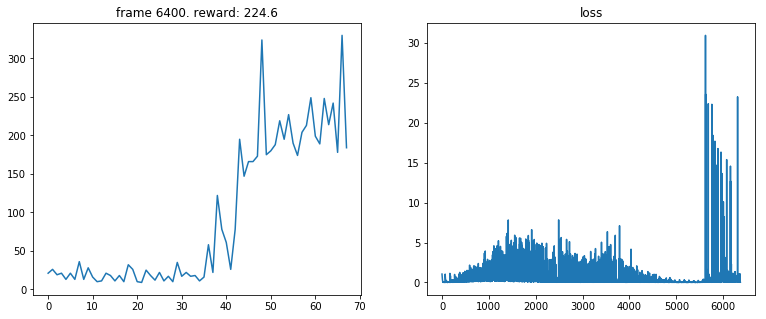

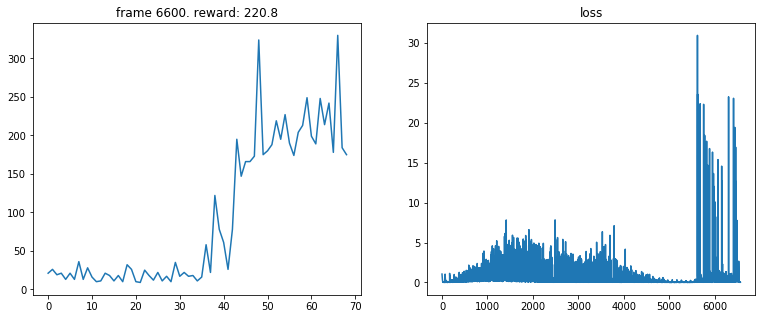

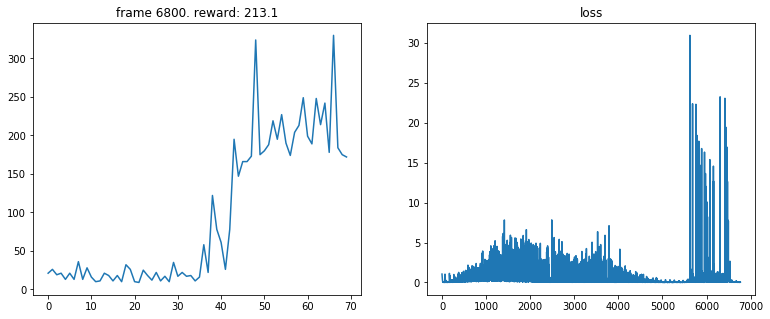

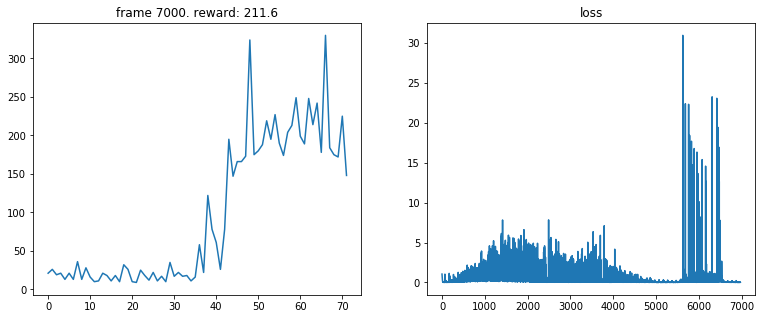

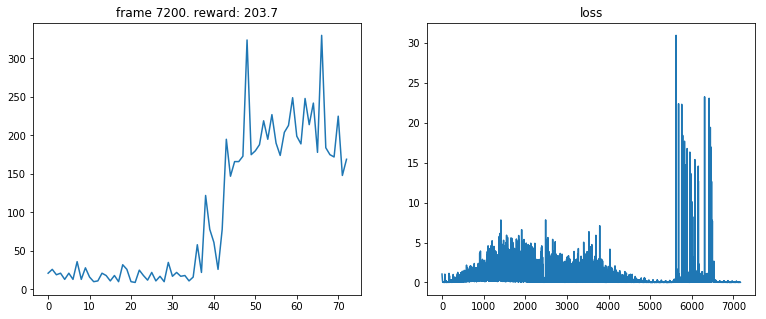

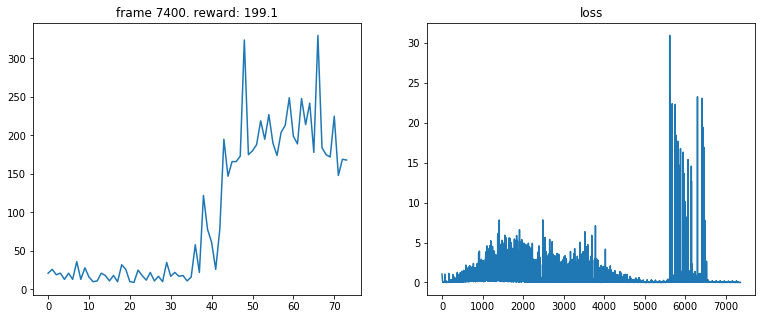

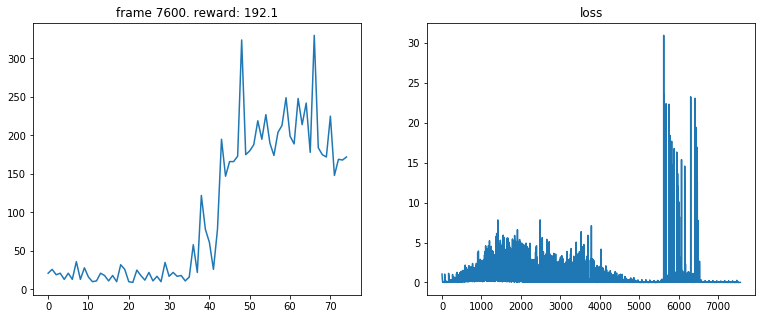

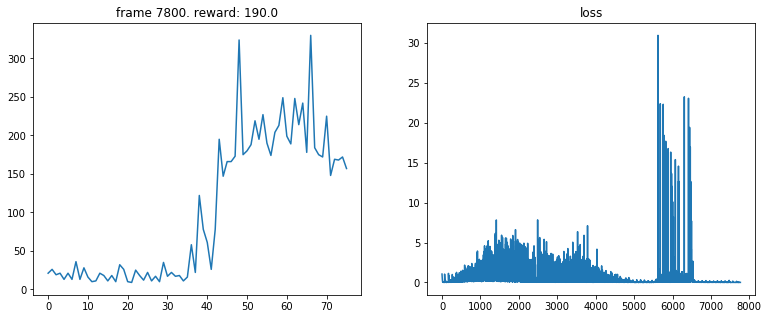

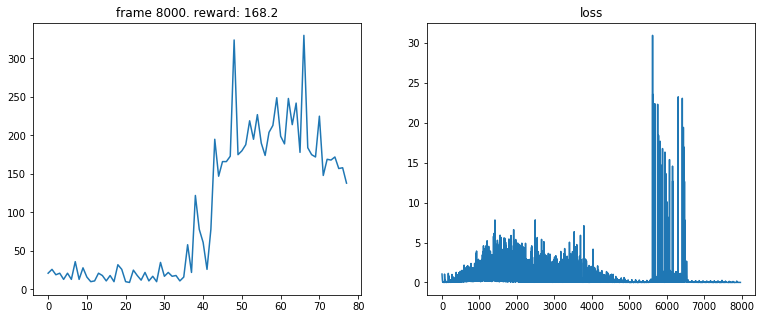

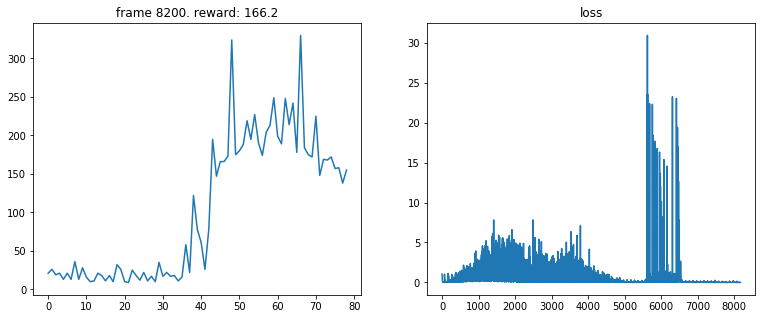

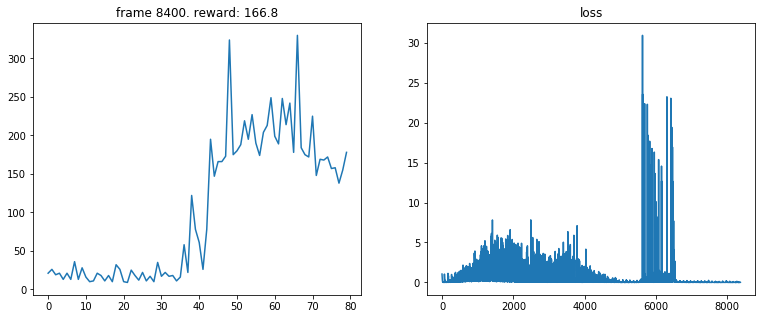

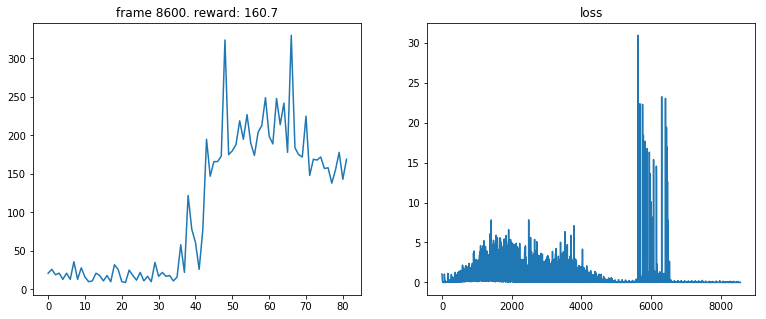

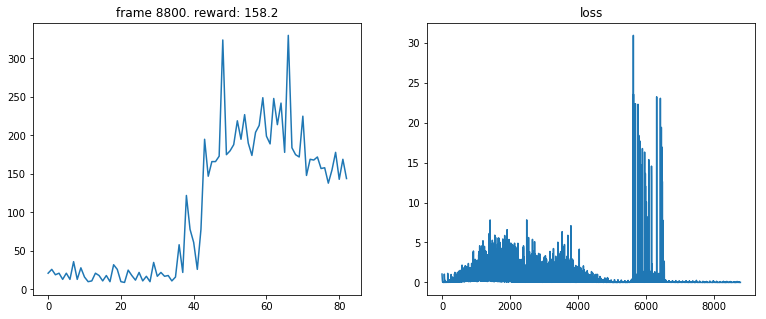

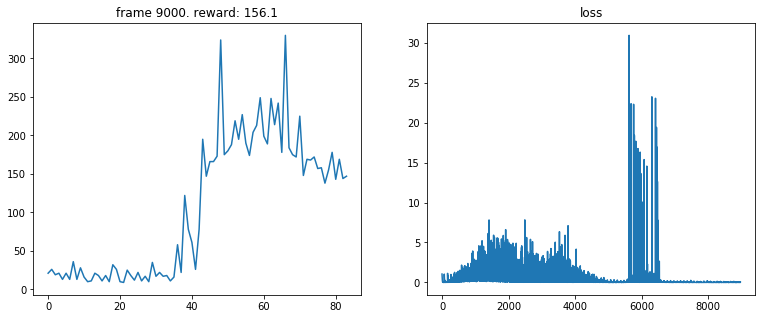

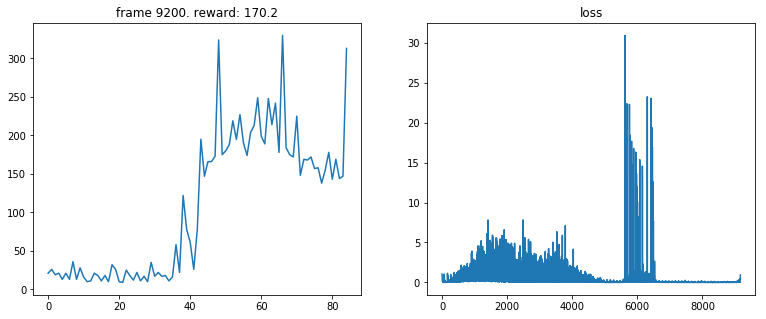

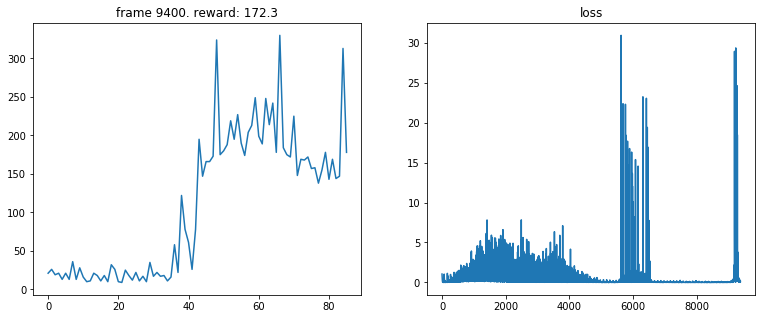

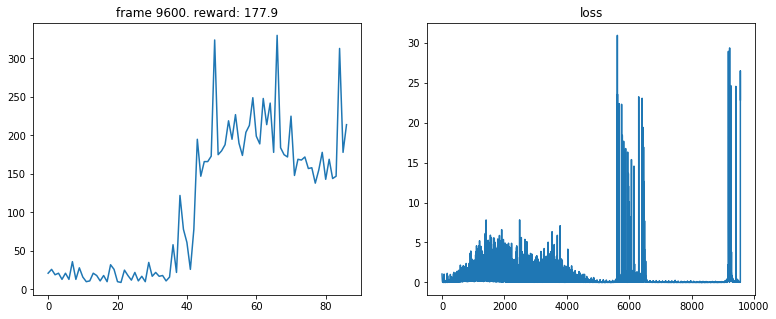

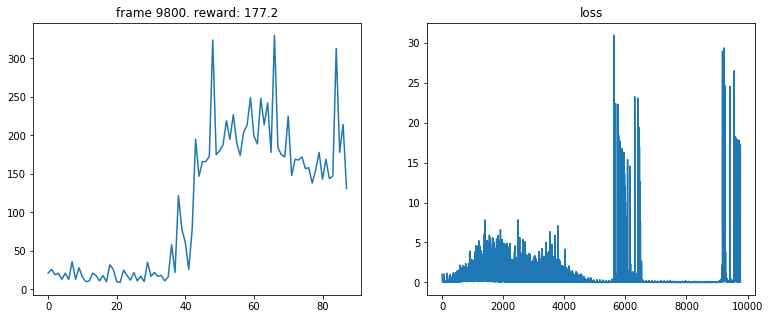

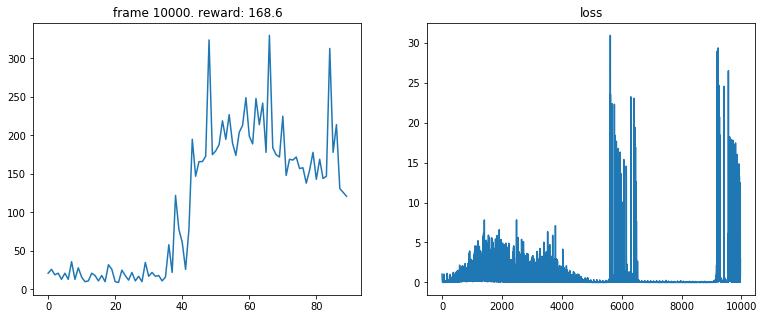

In [214]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)

    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if replay_buffer.length() > batch_size:
        loss = compute_td_loss(batch_size,gamma)
        losses.append(loss)

    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)